In [6]:
import os
import sys
import math
import time
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

# For classification (ResNet152V2)
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error

# For downloading pre-trained weights
import gdown

!git clone https://github.com/XGHouE/brain-tumor-analysis/

fatal: destination path 'brain-tumor-analysis' already exists and is not an empty directory.


# Data paths

UNet:

In [7]:
# Sort the image and mask filenames to ensure they match

IMAGES_PATH='/content/brain-tumor-analysis/split_dataset/UNet/scans'
MASKS_PATH='/content/brain-tumor-analysis/split_dataset/UNet/masks'
image_files = sorted(os.listdir(IMAGES_PATH))
mask_files = sorted(os.listdir(MASKS_PATH))
SIZE=256
CHANNEL=1
Num_Of_Classes=1

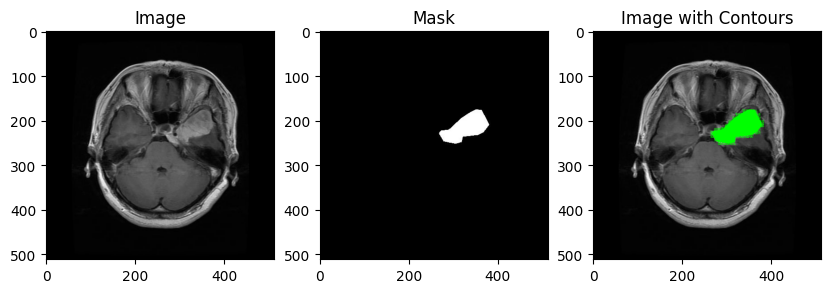

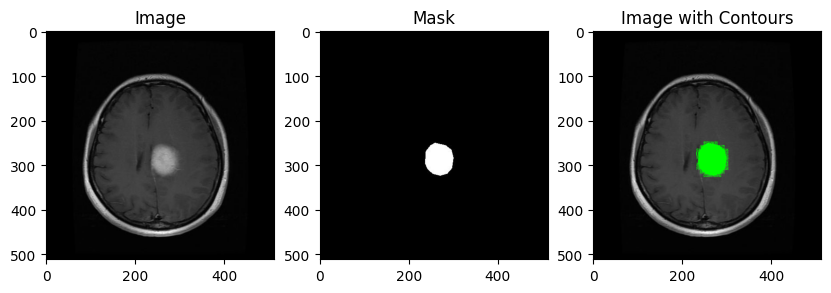

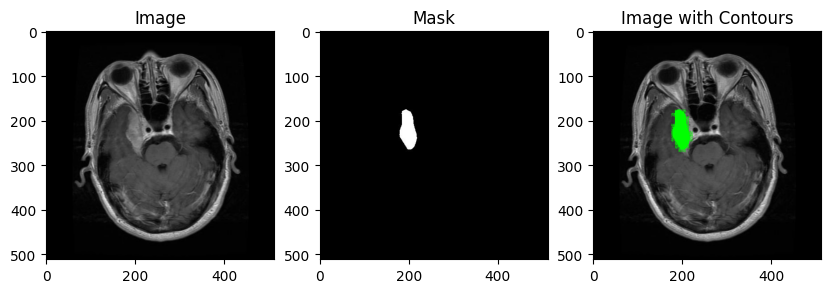

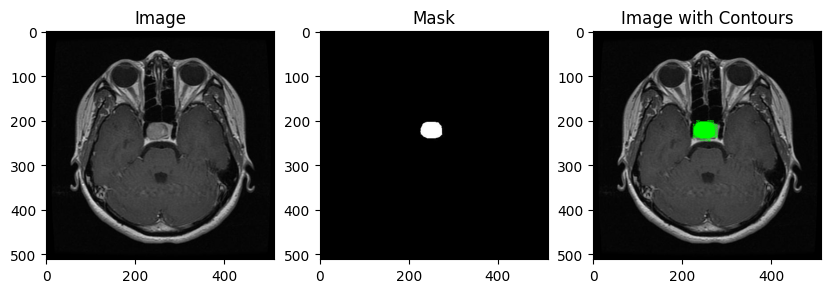

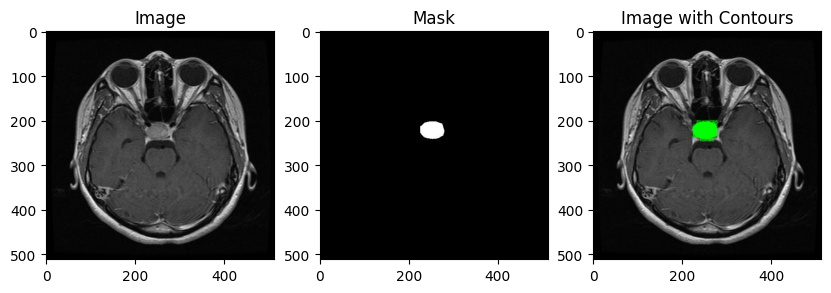

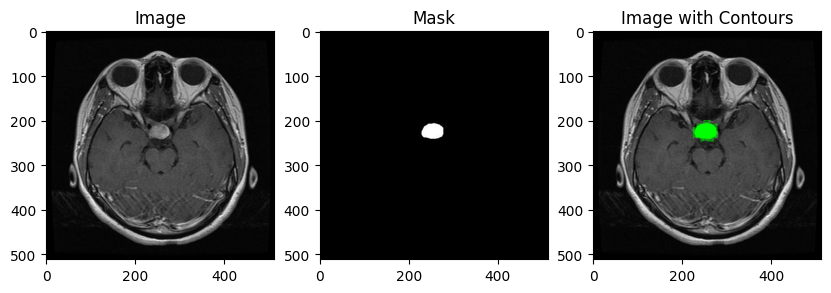

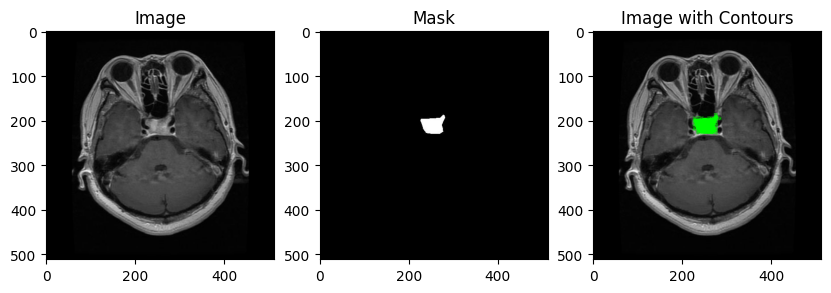

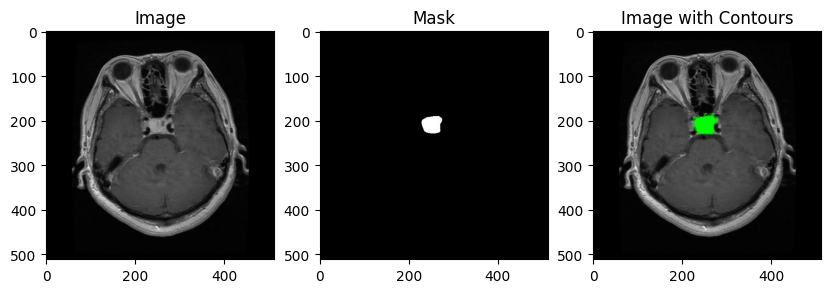

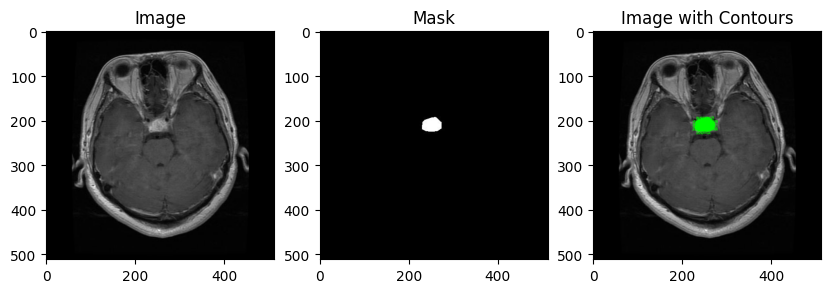

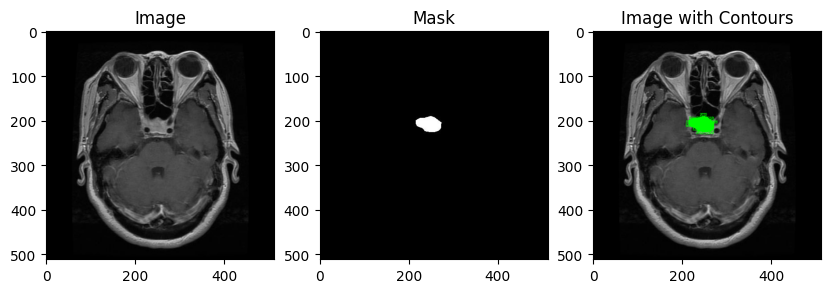

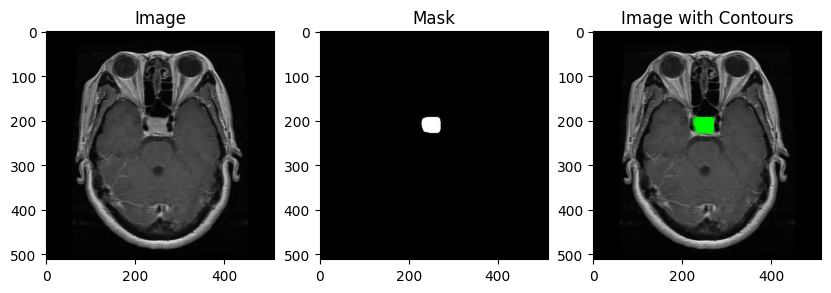

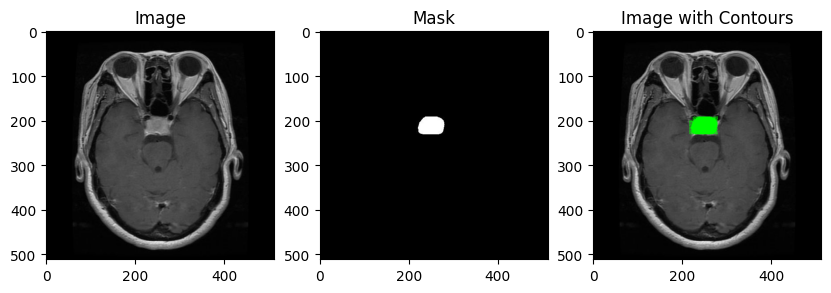

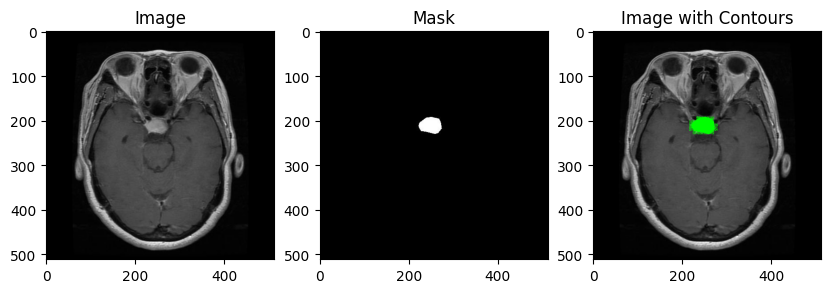

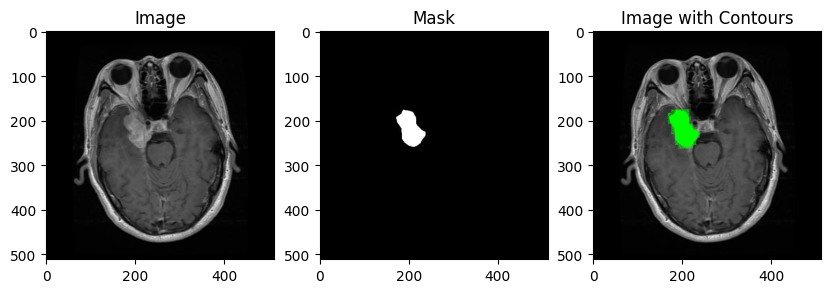

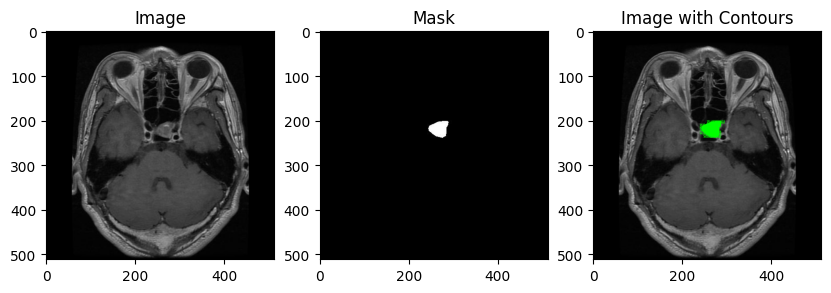

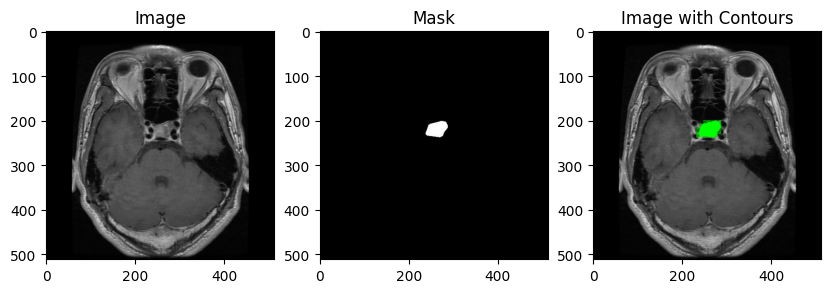

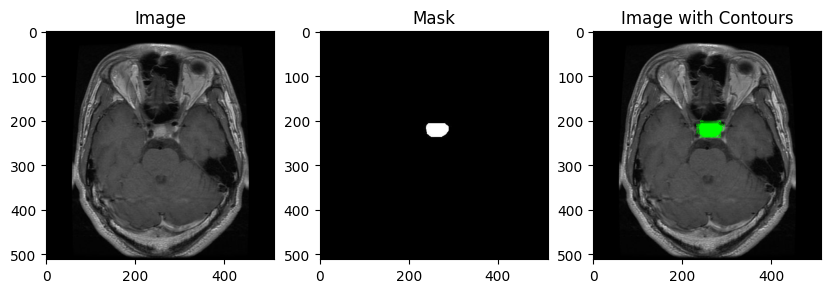

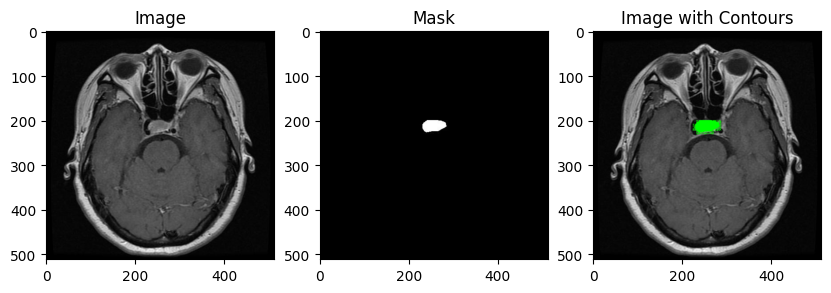

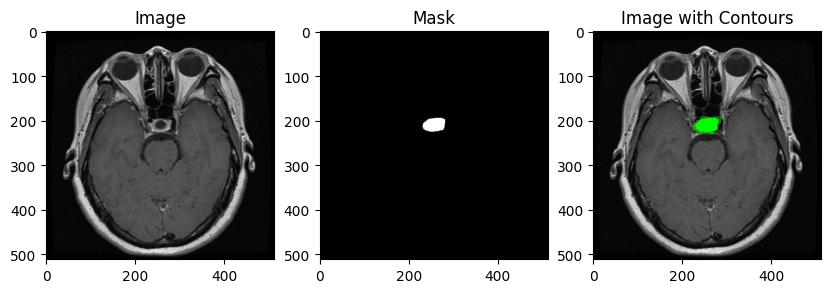

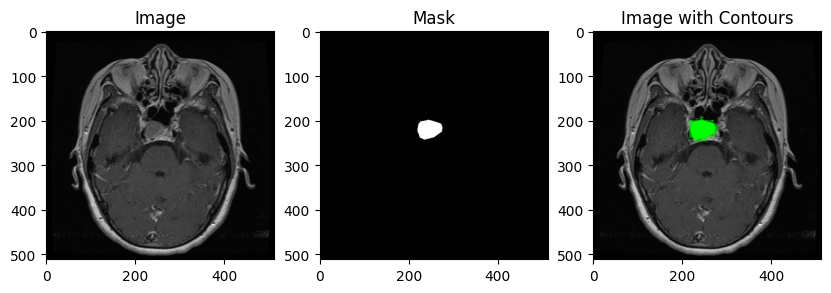

In [60]:
# Ensure data is imported correctly
def display_images_masks(imagepath, maskpath):
  count = 0
  for image_file, mask_file in zip(image_files, mask_files):
    if count >= 20:  # Display only the first 4 images from each folder
        break
    imagepath_full = os.path.join(imagepath, image_file)
    maskpath_full = os.path.join(maskpath, mask_file)
    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)
    if image is None:
        raise ValueError(f"Image at path {imagepath_full} could not be loaded")
    if mask is None:
        raise ValueError(f"Mask at path {maskpath_full} could not be loaded")
    plt.figure(figsize=(10, 10))
    # First subplot (image)
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    # Second subplot (mask)
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    # Third subplot (Image with Contours)
    plt.subplot(1, 3, 3)
    sample = np.array(np.squeeze(mask), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,1],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(image, contours, -1,[0,255,0], thickness=-1)
    plt.imshow(sample_over_gt)
    plt.title('Image with Contours')
    plt.show()
    count += 1

display_images_masks(IMAGES_PATH,MASKS_PATH)

In [9]:
images_size=[]
masks_size=[]
for image_file, mask_file in tqdm(zip(image_files, mask_files)):
    imagepath_full = os.path.join(IMAGES_PATH, image_file)
    maskpath_full = os.path.join(MASKS_PATH, mask_file)
    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)
    images_size.append(image.shape)
    masks_size.append(mask.shape)
print(list(set(images_size)))
print("=================")
print(list(set(masks_size)))

4569it [00:07, 628.45it/s]

[(488, 504, 3), (263, 236, 3), (290, 236, 3), (717, 717, 3), (444, 468, 3), (243, 236, 3), (674, 648, 3), (1446, 1375, 3), (210, 233, 3), (302, 216, 3), (530, 380, 3), (512, 434, 3), (251, 447, 3), (250, 201, 3), (274, 230, 3), (252, 236, 3), (442, 442, 3), (249, 201, 3), (320, 296, 3), (228, 233, 3), (218, 233, 3), (480, 853, 3), (725, 728, 3), (248, 208, 3), (484, 405, 3), (600, 600, 3), (483, 430, 3), (417, 428, 3), (506, 444, 3), (630, 630, 3), (223, 236, 3), (614, 630, 3), (344, 320, 3), (228, 235, 3), (273, 236, 3), (236, 236, 3), (243, 200, 3), (504, 450, 3), (244, 206, 3), (470, 469, 3), (273, 251, 3), (214, 229, 3), (496, 453, 3), (264, 235, 3), (248, 203, 3), (474, 356, 3), (1024, 1024, 3), (295, 236, 3), (277, 235, 3), (217, 232, 3), (600, 494, 3), (247, 204, 3), (216, 232, 3), (262, 224, 3), (238, 212, 3), (280, 229, 3), (216, 236, 3), (244, 262, 3), (201, 210, 3), (236, 211, 3), (236, 255, 3), (490, 410, 3), (201, 236, 3), (777, 622, 3), (442, 332, 3), (218, 225, 3), (469,

In [67]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files, mask_files)):
        imagepath_full = os.path.join(IMAGES_PATH, image_file)
        maskpath_full = os.path.join(MASKS_PATH, mask_file)
        image = cv2.imread(imagepath_full,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image = image/255.0
        images.append(image)
        mask = cv2.imread(maskpath_full,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
        mask = mask/255.0
        masks.append(mask)

    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [68]:
# Split train and test
X,y=preprocessing_images_masks()
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

4569it [00:08, 568.39it/s]


The Shape of X (4569, 256, 256, 1)
The Shape of y (4569, 256, 256, 1)
The shape of X_train (3655, 256, 256, 1)
The shape of y_train (3655, 256, 256, 1)
The shape of X_test (914, 256, 256, 1)
The shape of y_test (914, 256, 256, 1)


In [16]:
# Helpful metrics to define...
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

ResNet

In [24]:
train_dir = pathlib.Path("/content/brain-tumor-analysis/split_dataset/ResNet/Training Set")
test_dir = pathlib.Path("/content/brain-tumor-analysis/split_dataset/ResNet/Testing Set")

img_height = 256
img_width = 256
batch_size = 32
epochs = 30

In [81]:
# Data Preprocesssing
# Loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
    interpolation="bilinear",
    label_mode="int",
)

# Get class names
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

# Normalize and apply data augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 3654 files belonging to 4 classes.
Using 2924 files for training.
Classes in the dataset: ['Glioma', 'Meningioma', 'NoTumor', 'Pituitary']
Found 3654 files belonging to 4 classes.
Using 730 files for validation.
Found 915 files belonging to 4 classes.


In [26]:
# Different classes have different weights...
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")

    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())

    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

class_weight_dict = get_class_weights(train_ds, class_names)

Calculating class weights...
Class weights calculated.


# Define models

UNet

In [17]:
def unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=Num_Of_Classes):
    inputs = keras.layers.Input(input_size)

    # Encoding (Downsampling)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding (Upsampling)
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Create and compile the model
model = unet_model(input_size=(SIZE, SIZE,CHANNEL), num_classes=Num_Of_Classes)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy',dice_coef])
# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

ResNet

In [51]:
# Define the model
base_model3 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [63]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=1e-5, epochs=epochs, class_weight=None):
    for layer in base_model.layers[:10]:
      layer.trainable = False

    base_model_output = base_model.output
    x = layers.GlobalAveragePooling2D()(base_model_output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    print(f"\nSummary of {model_name}:")
    model.summary()

    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End time tracking
    end_time = time.time()

    # Calculate computation time
    computation_time = end_time - start_time

    print(f"Model training took {computation_time:.2f} seconds.")

    print(f"\nEvaluating {model_name}...")
    print(f"\nClass Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)

    return model, history, evaluation, computation_time

# Training

UNet

In [53]:
earlystopping=tf.keras.callbacks.EarlyStopping(patience=20,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 patience=15,
                                                 min_lr=1e-6,
                                                 mode='min')
history = model.fit(X_train, y_train, batch_size=32, epochs=30,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[earlystopping, reduce_lr])
model.save(f'unet_original.keras')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1928']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


229/229 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.7674 - dice_coef: 0.0431 - loss: 0.9569 - val_accuracy: 0.9859 - val_dice_coef: 0.2579 - val_loss: 0.7452 - learning_rate: 1.0000e-05
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9584 - dice_coef: 0.1981 - loss: 0.8019 - val_accuracy: 0.9861 - val_dice_coef: 0.3304 - val_loss: 0.6743 - learning_rate: 1.0000e-05
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9839 - dice_coef: 0.3035 - loss: 0.6965 - val_accuracy: 0.9875 - val_dice_coef: 0.4066 - val_loss: 0.5990 - learning_rate: 1.0000e-05
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9862 - dice_coef: 0.3829 - loss: 0.6171 - val_accuracy: 0.9887 - val_dice_coef: 0.4591 - val_loss: 0.5465 - learning_rate: 1.0000e-05
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9868 - dice_coef: 0.4118 - loss: 0.5882 - val_accuracy: 0.9857 - val_dice_coef: 0.4468 - val_loss: 0.5538 - learning_rate: 1.0000e-05


ResNet

In [54]:
print(train_ds)
model3, history3, evaluation3, time3 = create_and_train_model(base_model3, 'model3_resnet152v2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Summary of model3_resnet152v2_class_weights:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 64, 64, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 64, 64, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 66, 66, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 59,382,788 (226.53 MB)

 Trainable params: 59,225,220 (225.93 MB)

 Non-trainable params: 157,568 (615.50 KB)

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 258s 667ms/step - accuracy: 0.5791 - loss: 5.0136 - val_accuracy: 0.3534 - val_loss: 643.3976 - learning_rate: 0.0010
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 66s 360ms/step - accuracy: 0.7357 - loss: 0.9395 - val_accuracy: 0.7671 - val_loss: 1.0594 - learning_rate: 0.0010
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.7573 - loss: 0.7619 - val_accuracy: 0.5370 - val_loss: 2.3747 - learning_rate: 0.0010
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.7577 - loss: 0.7249 - val_accuracy: 0.4164 - val_loss: 2.2635 - learning_rate: 0.0010
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 336ms/step - accuracy: 0.8112 - loss: 0.5961 - val_accuracy: 0.3890 - val_loss: 3.2183 - learning_rate: 0.0010
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.8152 - loss: 0.5688 - val_accuracy: 0.3986 - val_loss: 10.3343 - learning_rate: 0.0010
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 66s 359ms/step - accuracy:

# Evaluation

UNet

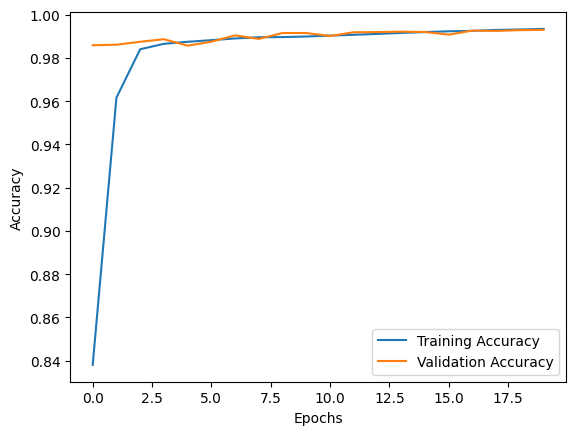

In [55]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

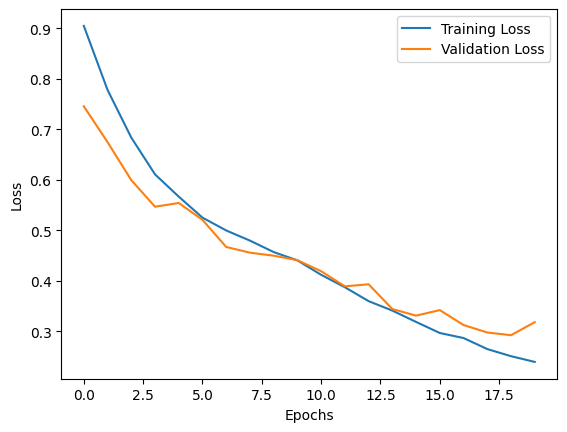

In [56]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
u_net_loss,u_net_accuracy,u_net_dice_coef=model.evaluate(X_test,y_test)
print(f'Loss is {u_net_loss}')
print(f'Accuracy is {u_net_accuracy}')
print(f'Dice_Coef is {u_net_dice_coef}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9937 - dice_coef: 0.7014 - loss: 0.2986
Loss is 0.31759315729141235
Accuracy is 0.9929875135421753
Dice_Coef is 0.6830326318740845


In [58]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1928']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


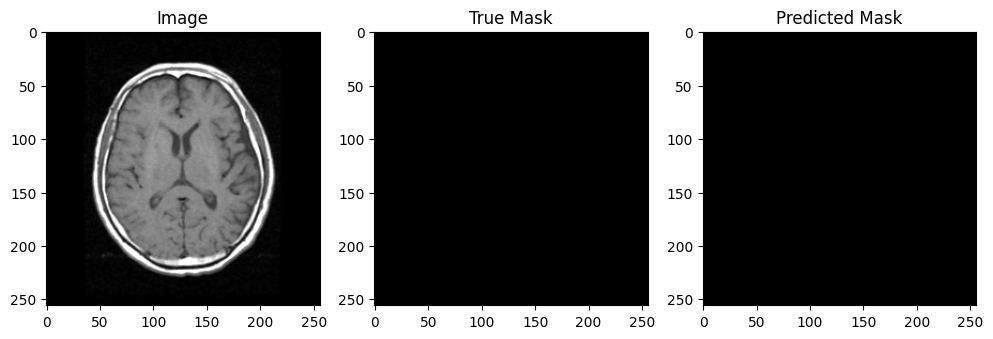

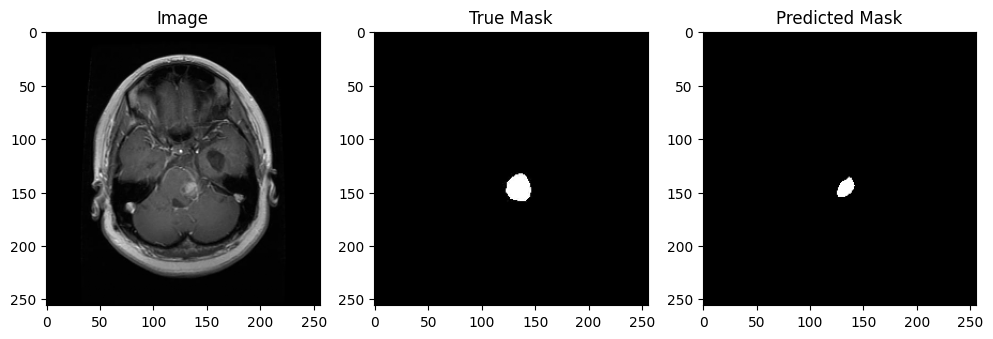

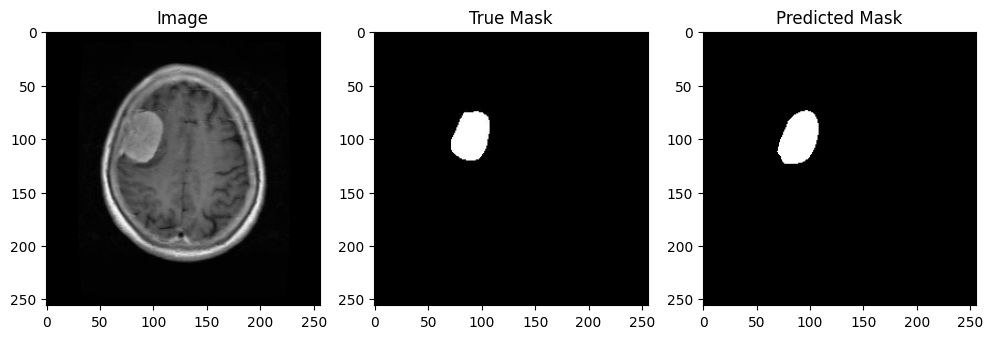

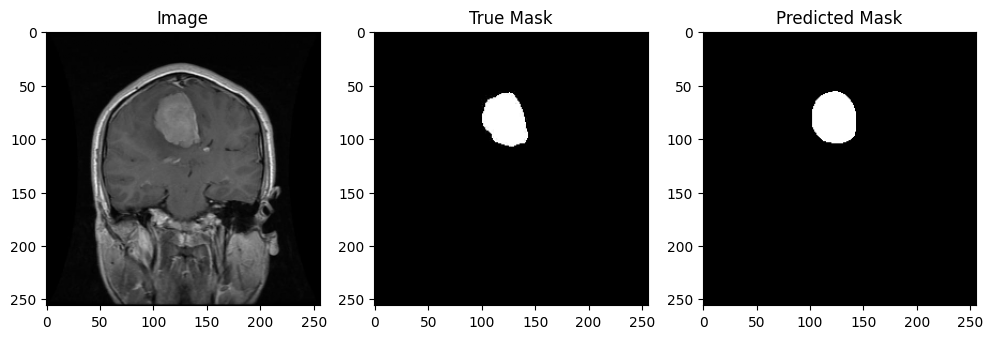

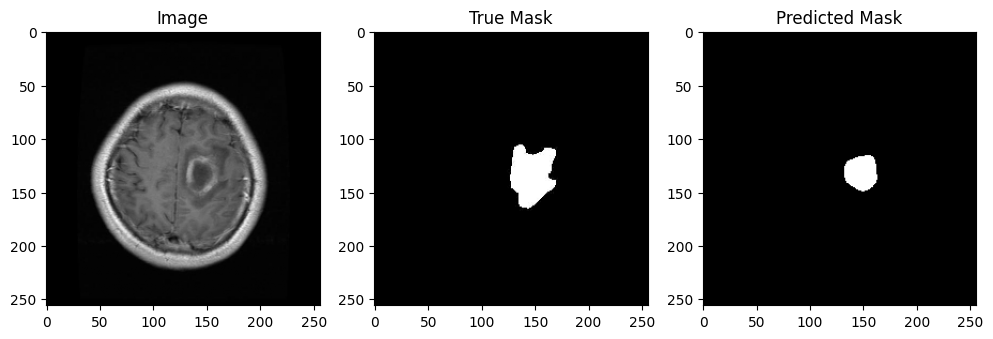

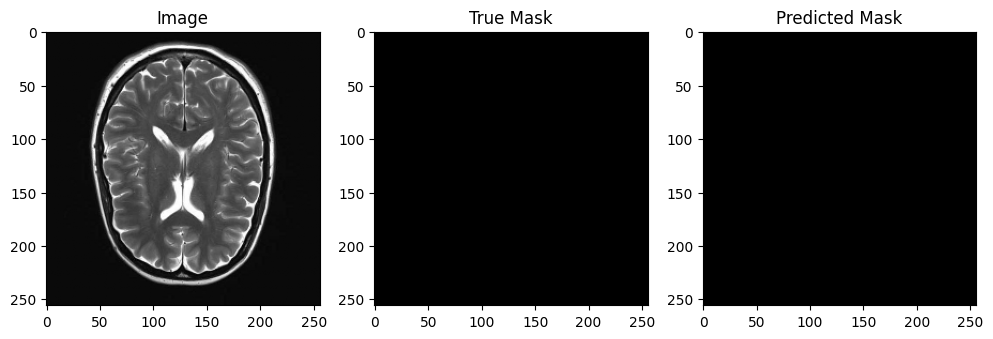

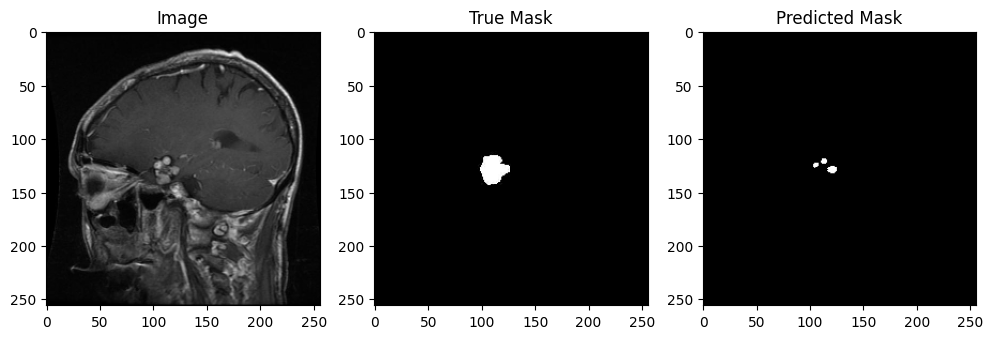

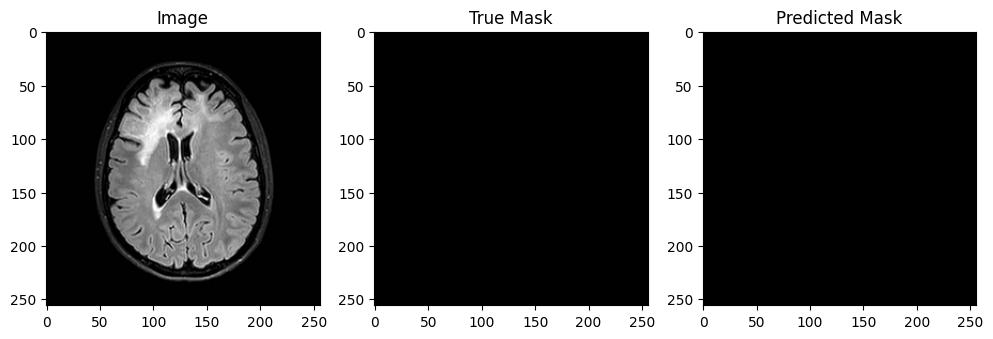

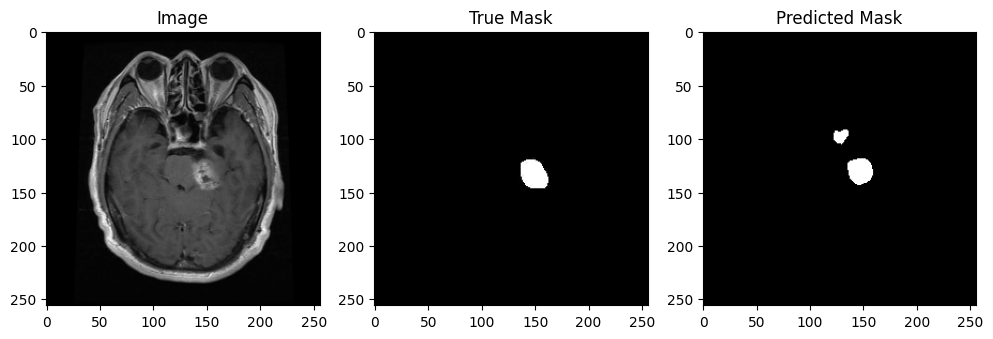

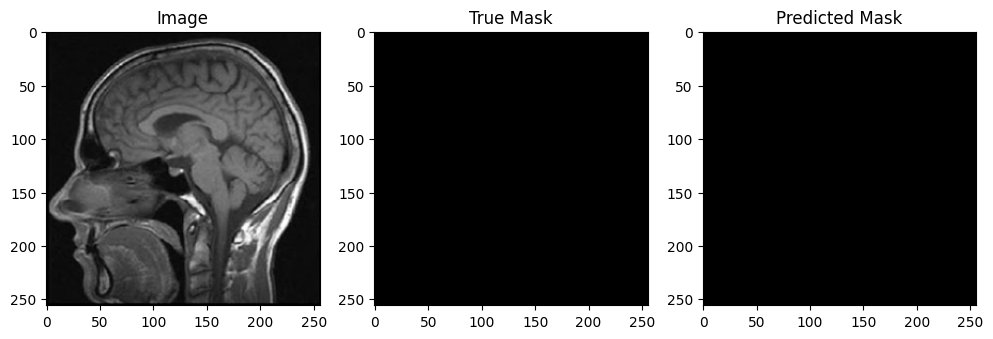

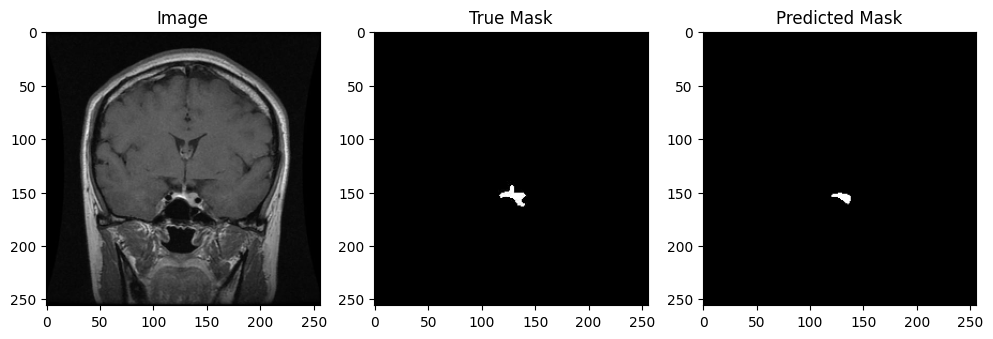

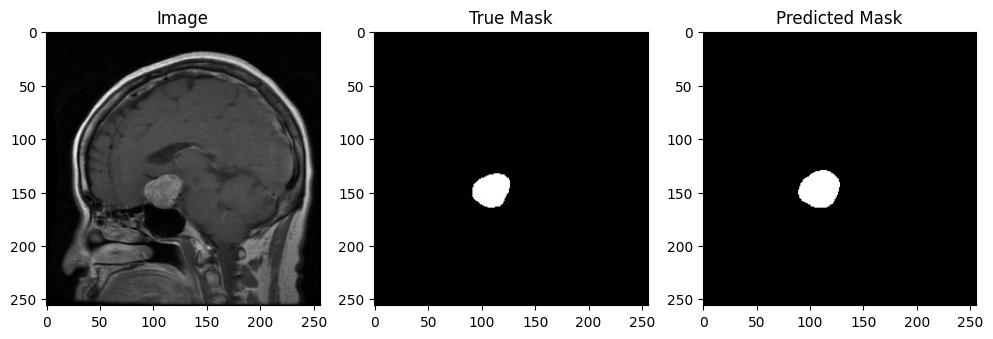

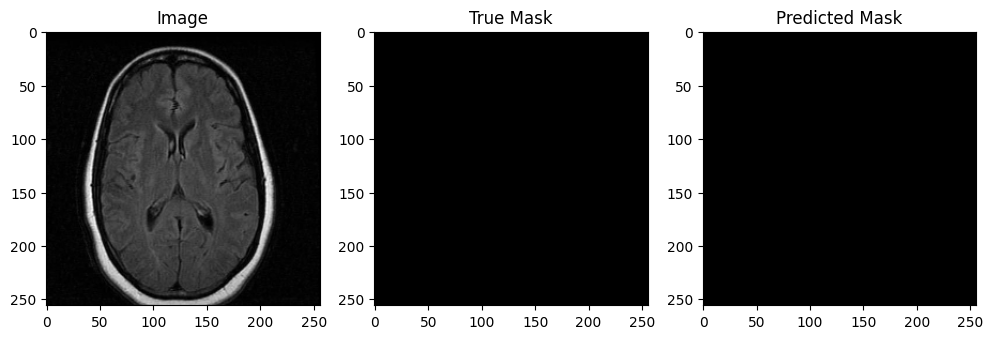

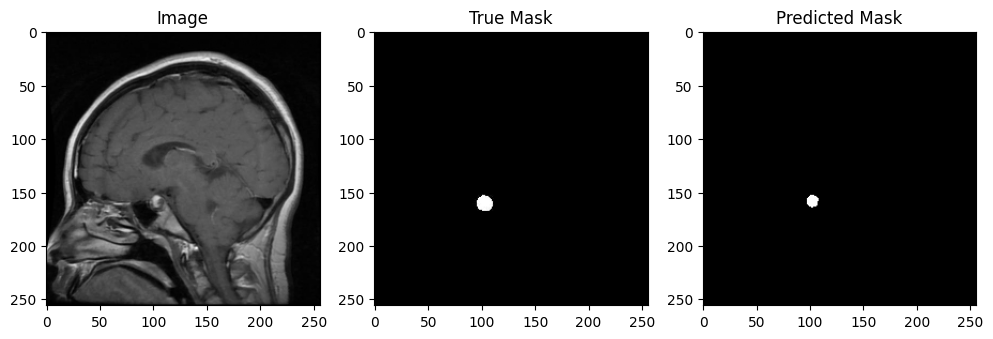

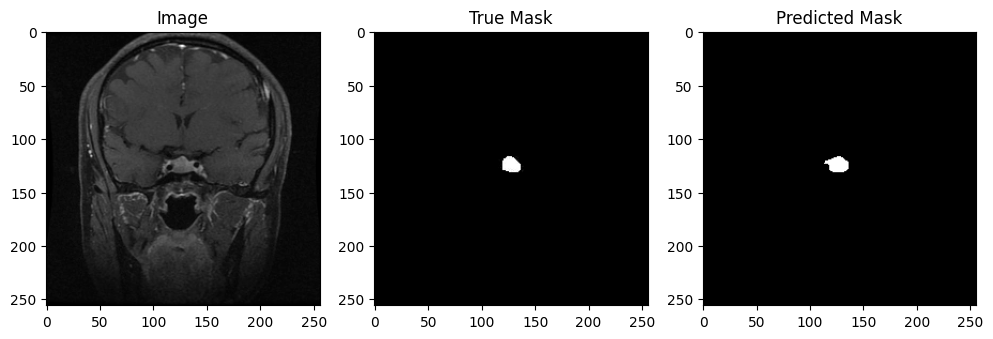

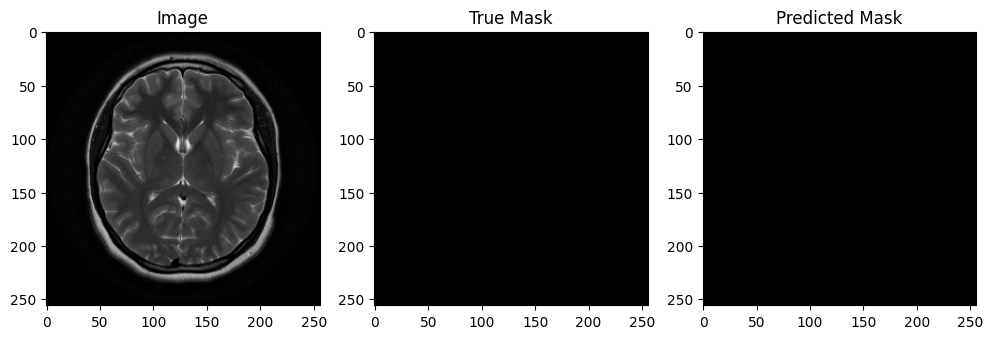

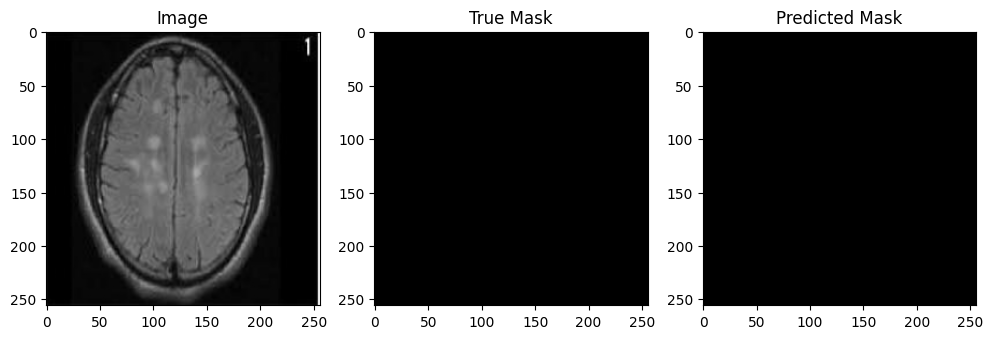

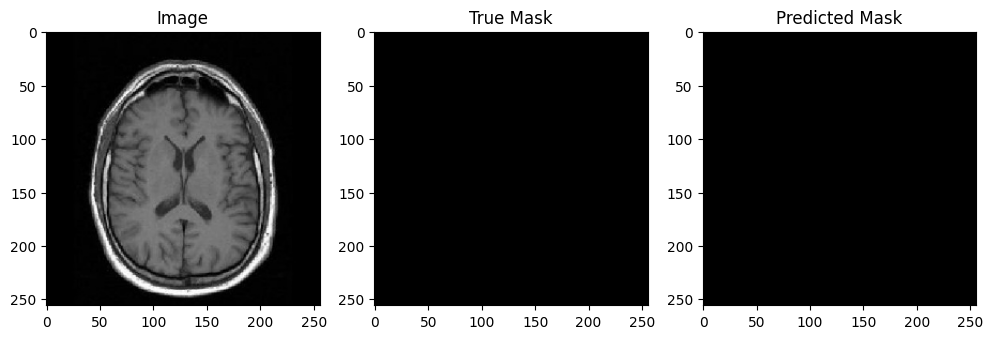

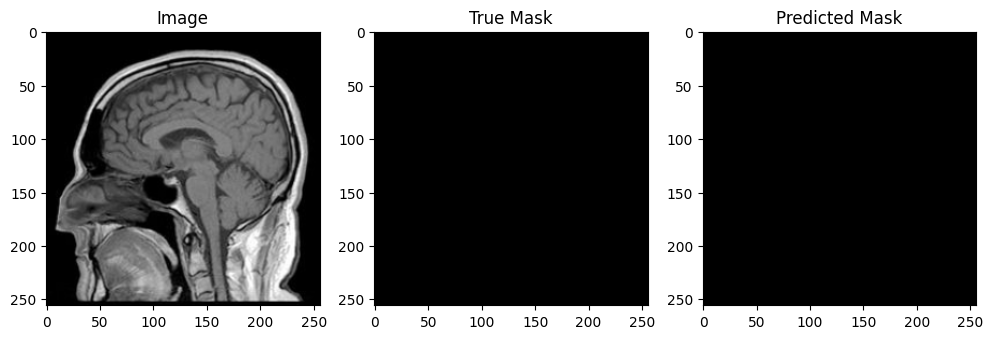

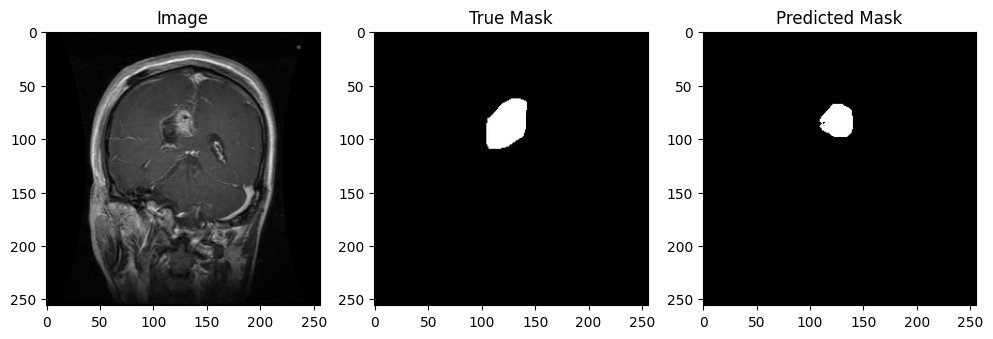

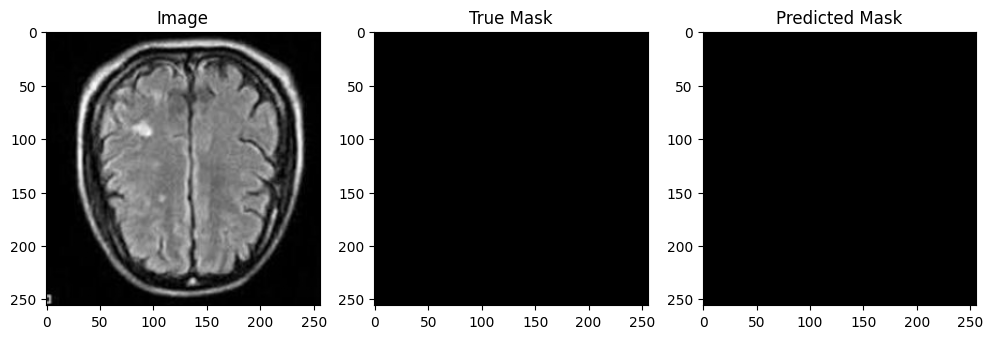

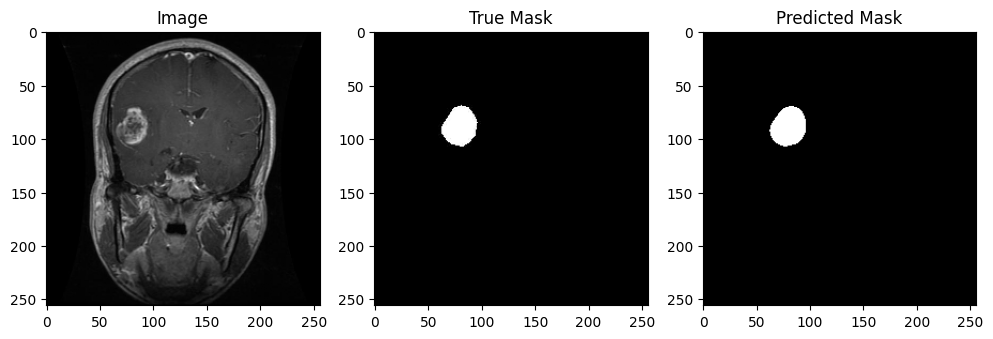

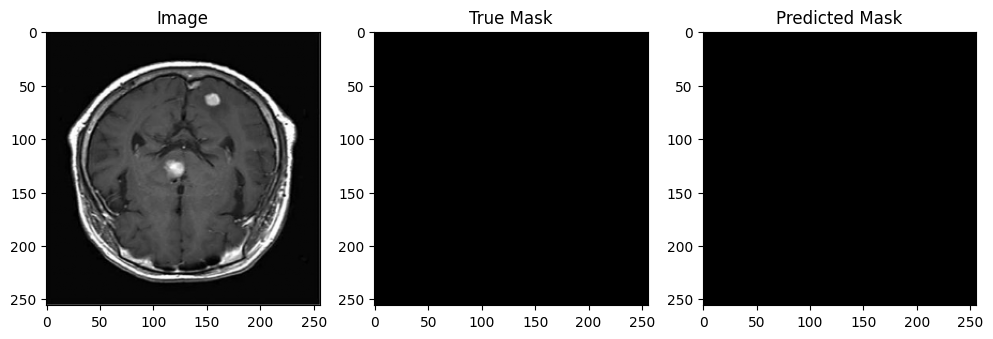

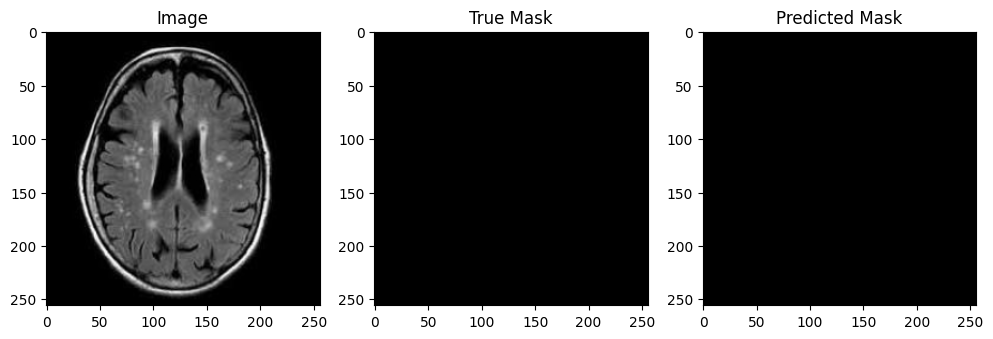

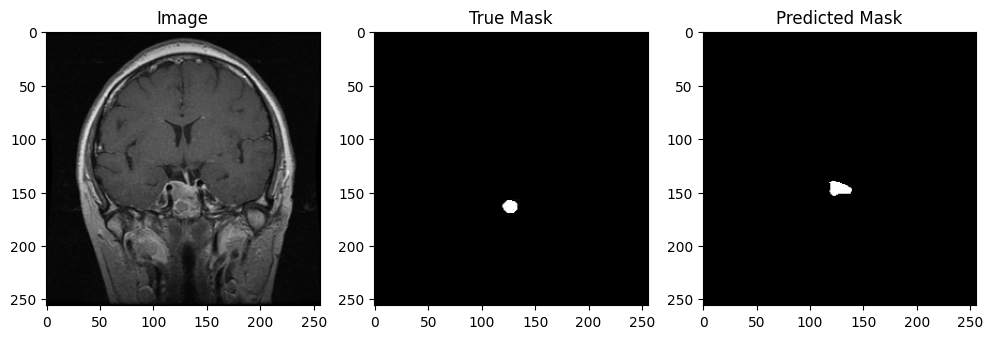

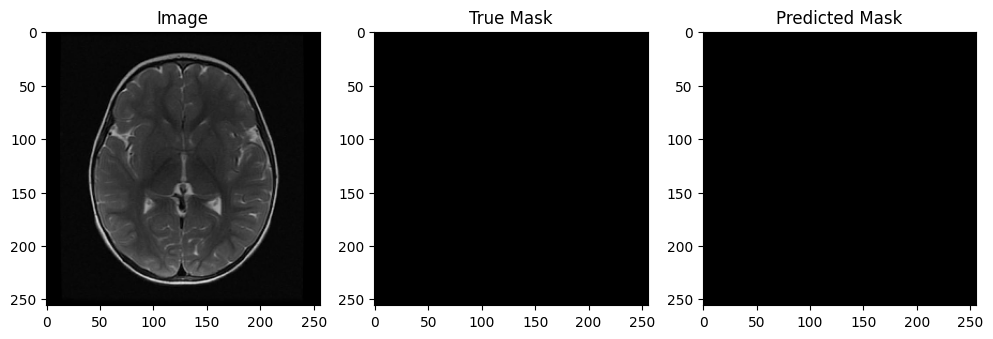

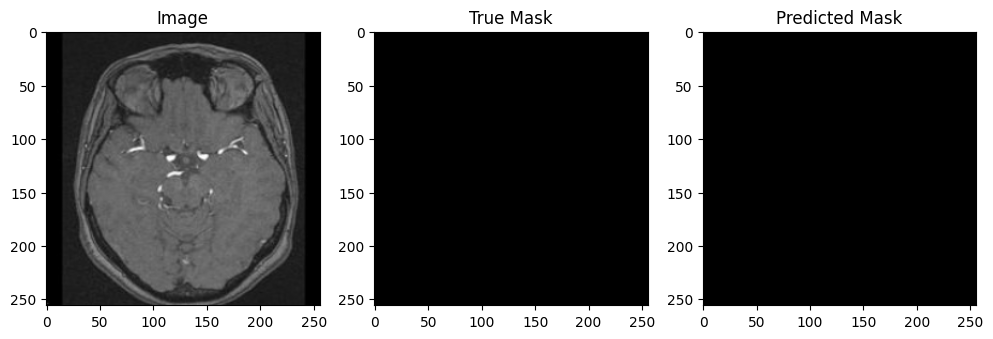

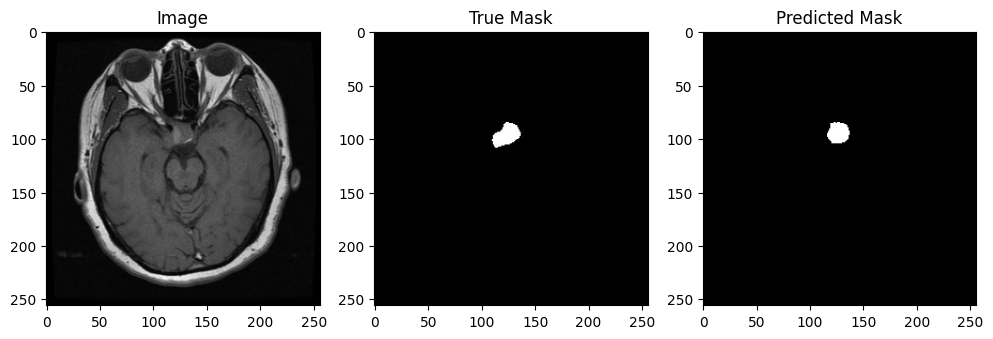

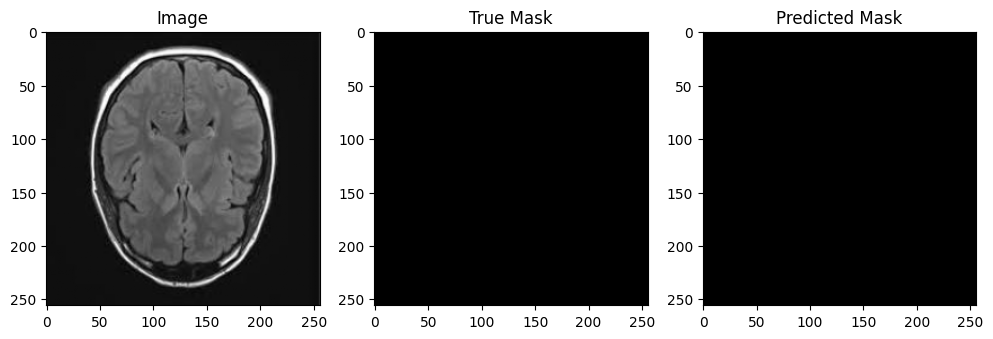

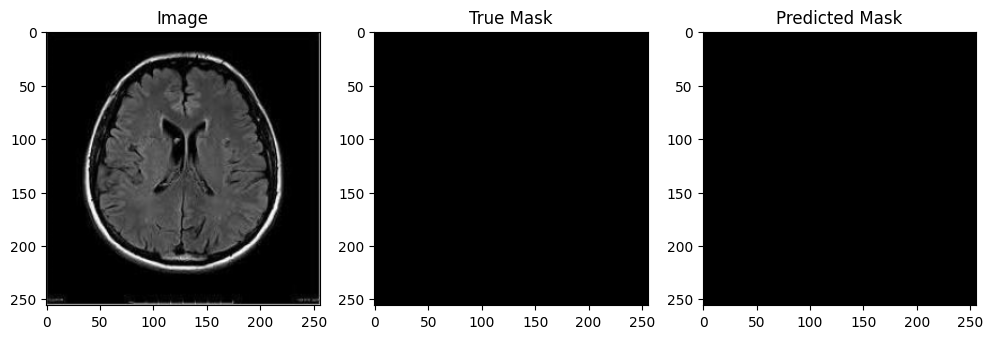

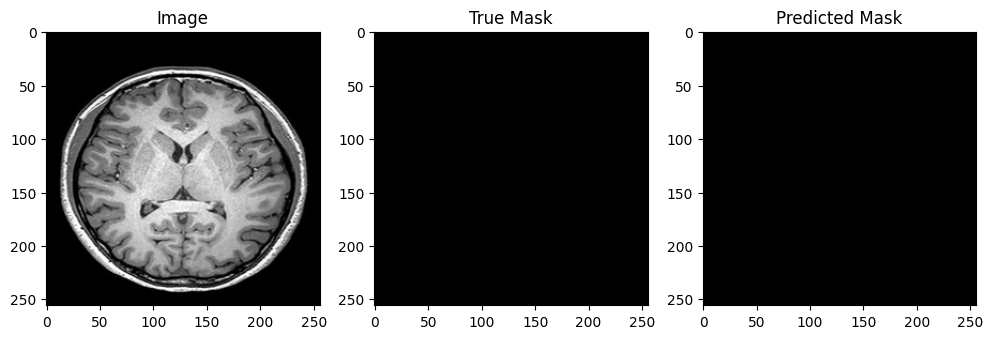

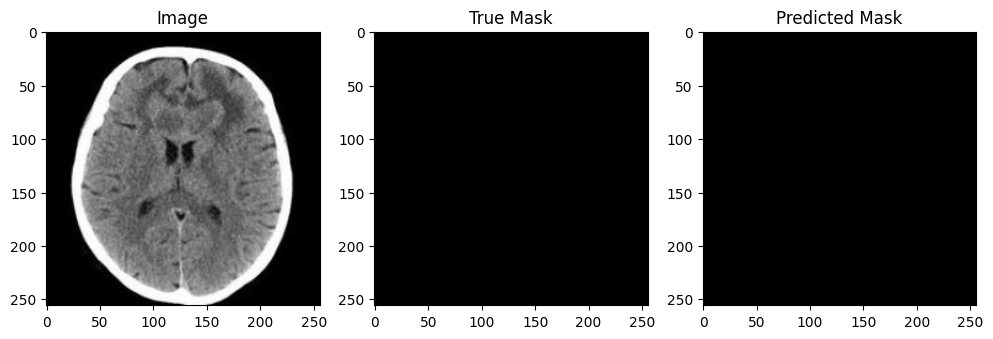

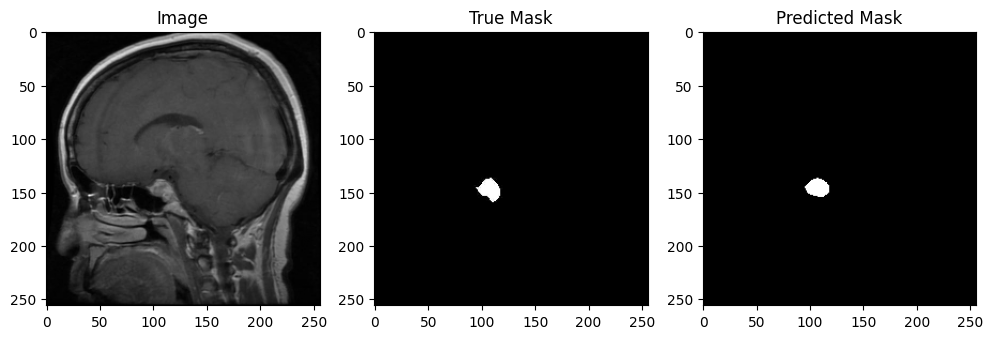

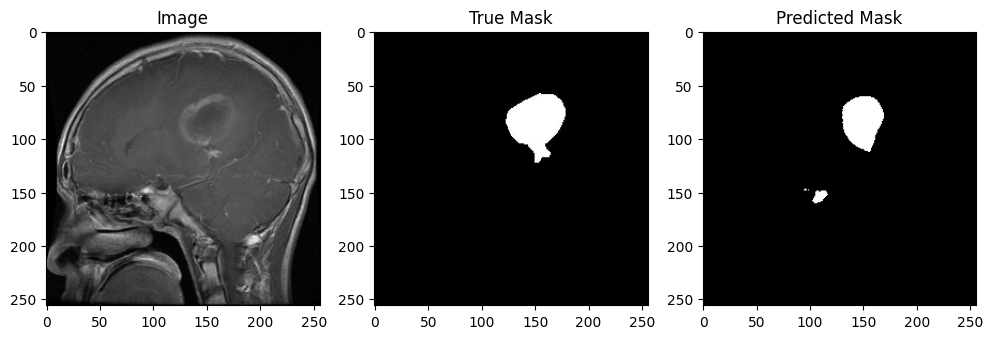

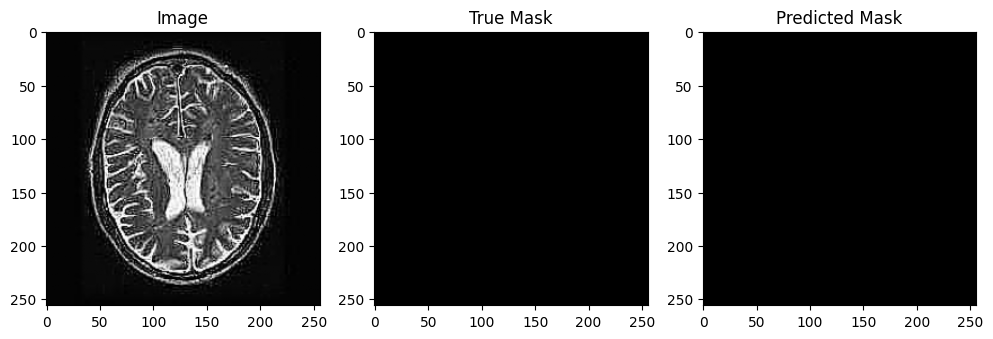

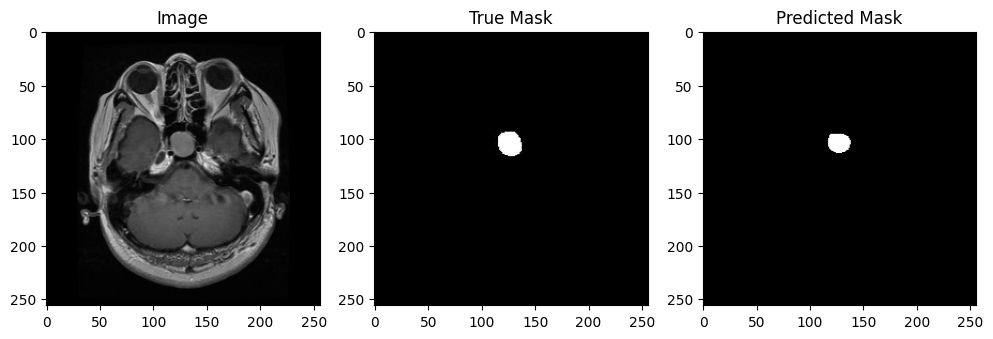

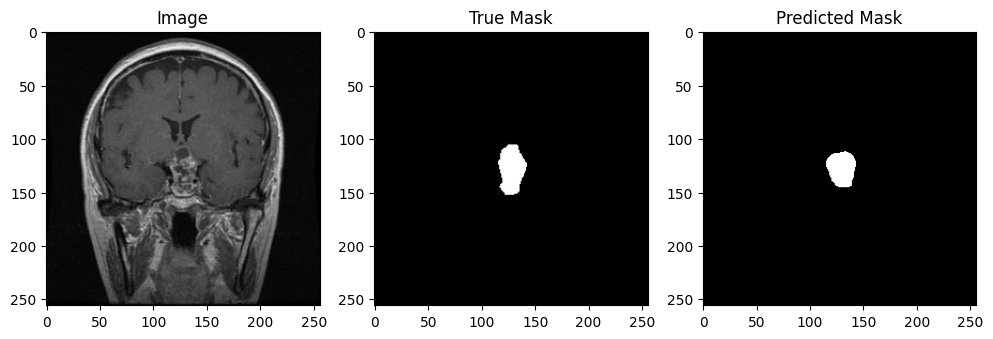

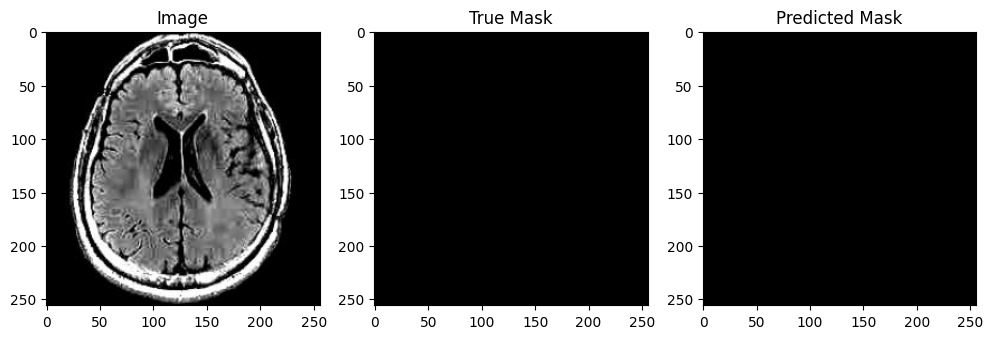

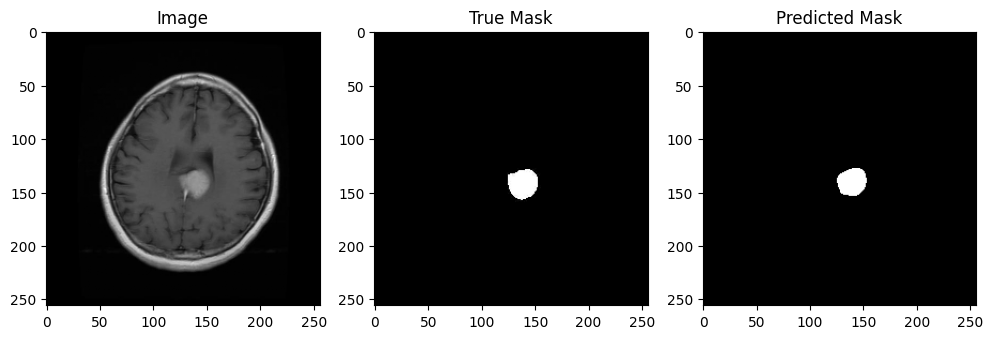

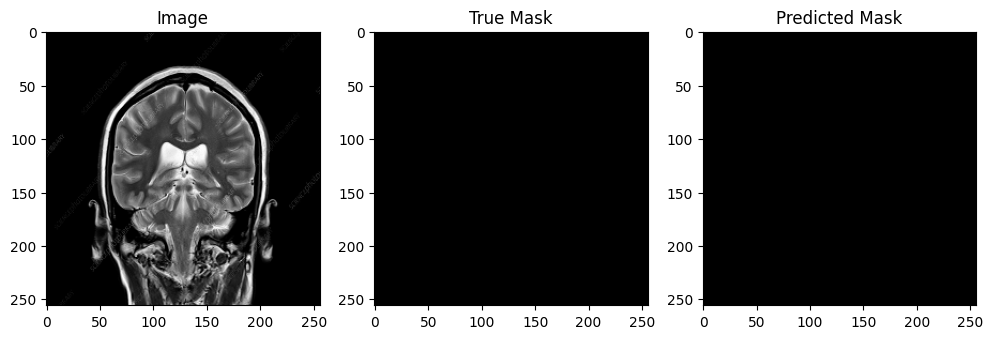

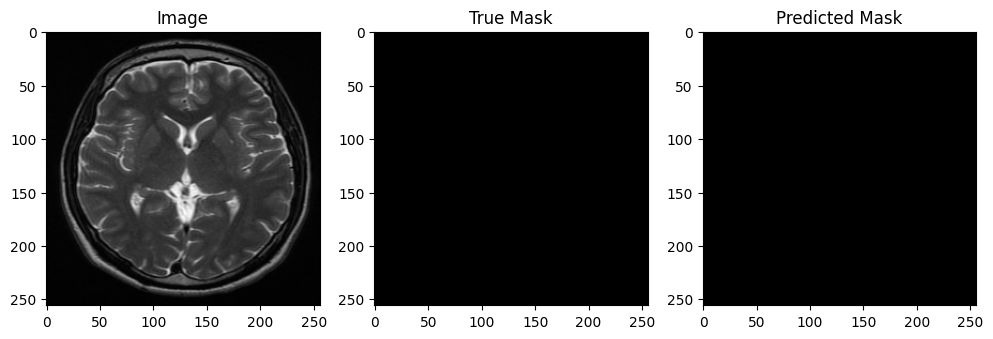

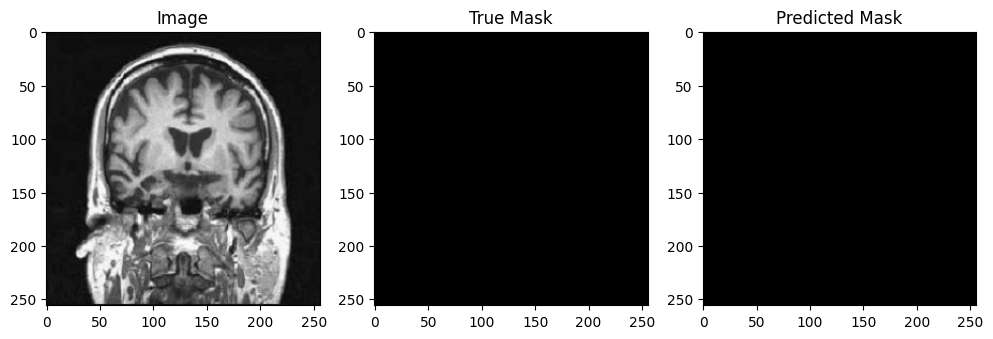

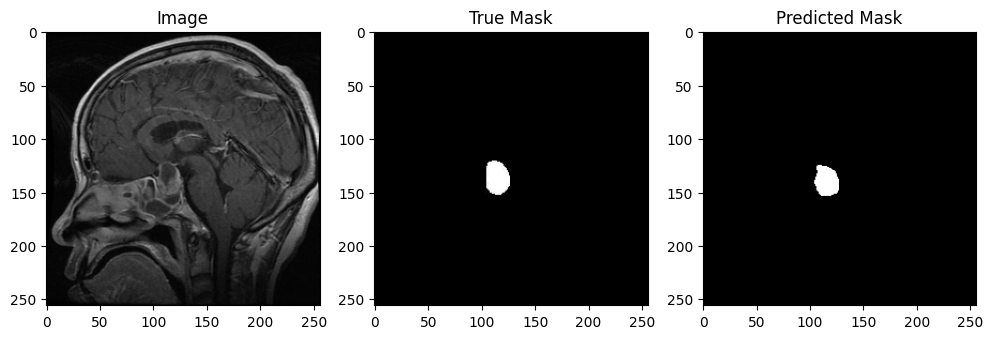

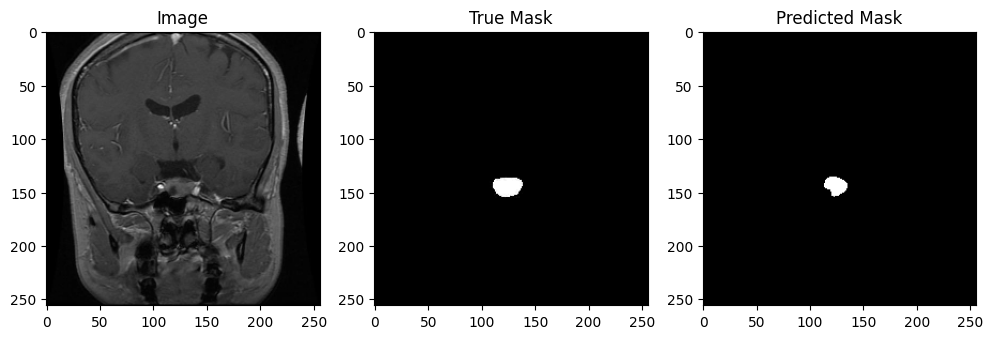

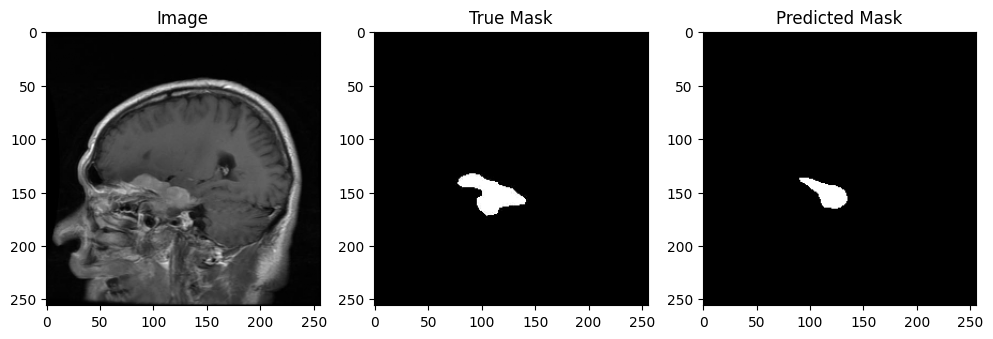

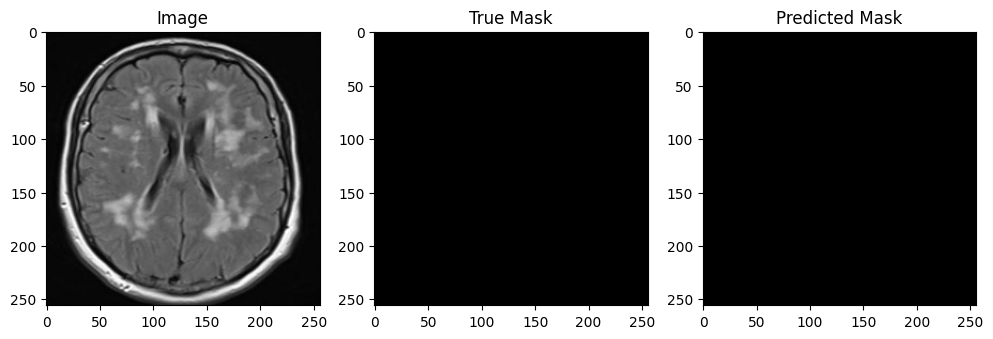

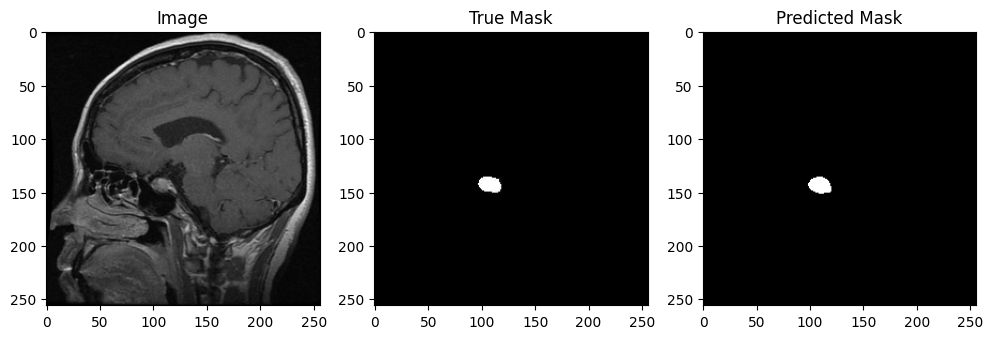

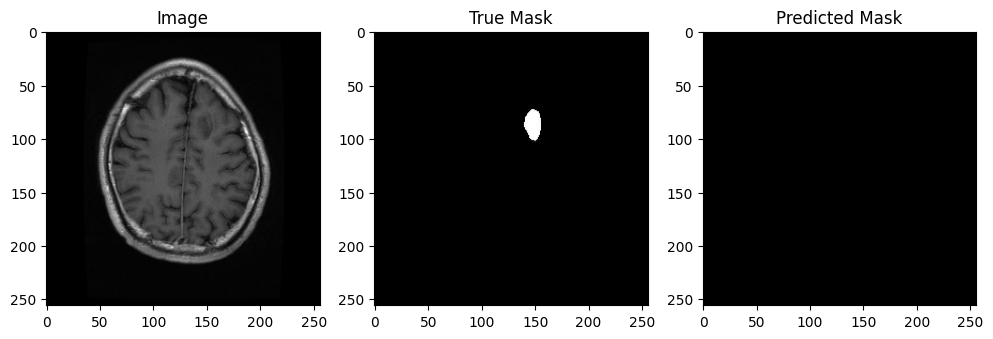

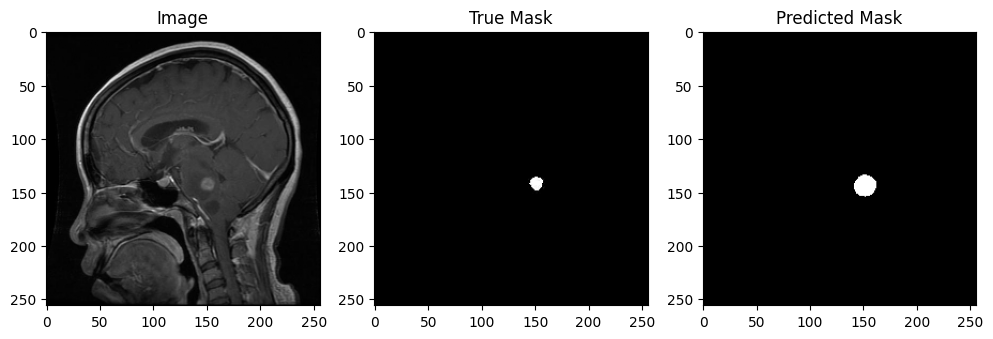

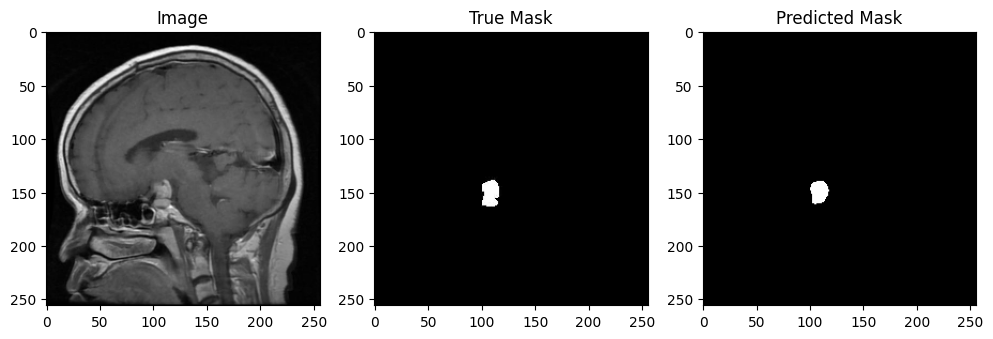

In [59]:
for i in range(50):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()

ResNet

In [60]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, precision, recall, f1, mae, rmse, cm

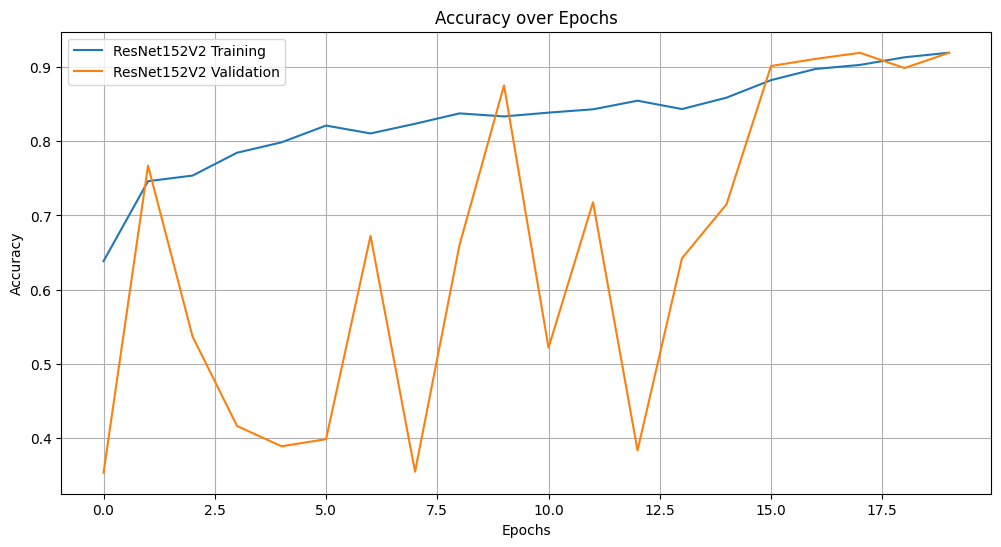

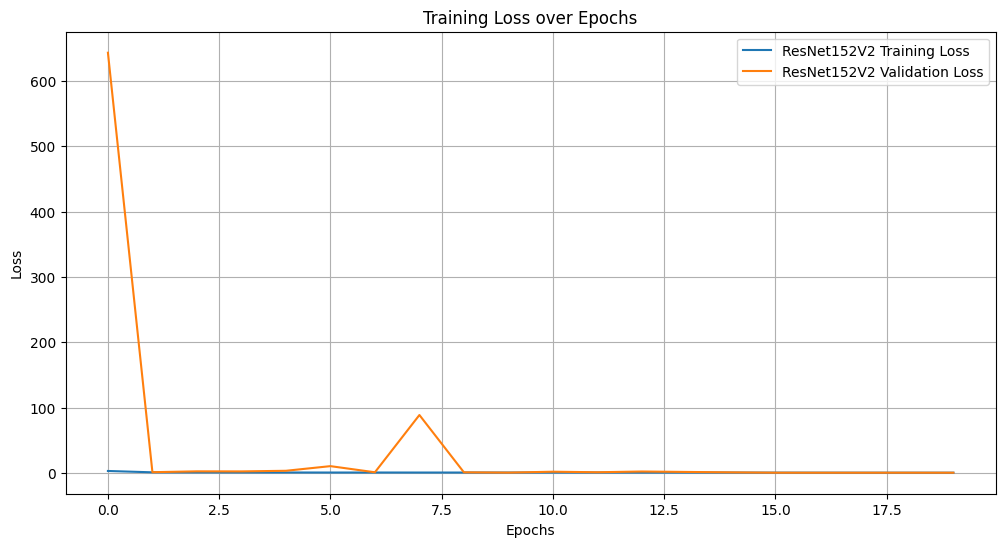

In [61]:
# Define model names
model_names = ["ResNet152V2"]

# Store histories in a list
histories = [history3]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} Training')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Second Iteration

UNet Modified

In [18]:
def unet_model_with_attention(
    input_size=(256, 256, 1),
    attn_size=(16, 16, 1),
    num_classes=1
):
    # --- Inputs ---
    unet_input = layers.Input(shape=input_size, name="unet_input")
    attention_input = layers.Input(shape=attn_size, name="attention_map_input")

    # --- Encoding (Downsampling) ---
    c1 = layers.Conv2D(64, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(unet_input)
    c1 = layers.Conv2D(64, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # --- Bottleneck ---
    c5 = layers.Conv2D(1024, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c5)

    # ------ Inject attention map by element-wise multiply ------
    # c5: (None, 16, 16, 1024)
    # attention_input: (None, 16, 16, 1)
    # broadcast across 1024 channels
    c5_with_attn = layers.multiply([c5, attention_input])
    # or, simply: c5 * attention_input if you prefer functional

    # --- Decoding (Upsampling) ---
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5_with_attn)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # --- Output layer ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    # Build Model with two inputs
    model = keras.models.Model(
        inputs=[unet_input, attention_input],
        outputs=[outputs]
    )
    return model

# Create and compile the new 2-input model
model_mod = unet_model_with_attention(
    input_size=(256, 256, 1),  # e.g. (256,256,1)
    attn_size=(16, 16, 1),            # attention map shape
    num_classes=1
)

model_mod.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy', dice_coef]
)

# Print the updated architecture
model_mod.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ unet_input (InputLayer)   │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ unet_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_map_input       │ (None, 16, 16, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 16, 16, 1024)   │              0 │ conv2d_28[0][0],       │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

ResNet with modification

In [19]:
def create_resnet_with_context(
    input_shape=(256,256,3),
    context_shape=(7,7,1),
    num_classes=4,
    freeze_up_to=10,
    base_learning_rate=1e-4
):
    """
    Returns a Keras model that:
      1) Takes an image of shape `input_shape`
      2) Takes a context map of shape `context_shape`
      3) Multiplies the final conv (7x7x2048) by the (7x7x1) context
      4) Classifies into `num_classes`.
    """

    # 1) Two inputs
    resnet_input = layers.Input(shape=input_shape, name="resnet_input")
    context_input = layers.Input(shape=context_shape, name="context_map_input")  # (7,7,1)

    # 2) Build (or load) ResNet152V2, include_top=False
    #    We'll pass `resnet_input` via `input_tensor=...` or do a separate Model approach
    base_model = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3)
    )

    # Optionally freeze some layers
    for layer in base_model.layers[:freeze_up_to]:
        layer.trainable = False

    # 3) Get final conv output: shape ~ (None, 7, 7, 2048)
    final_conv = base_model.output

    # 4) Multiply final_conv by the context map.
    #    (7,7,1) will broadcast to (7,7,2048).
    final_conv_with_context = layers.Multiply()([final_conv, context_input])

    # 5) Classification Head
    x = layers.GlobalAveragePooling2D()(final_conv_with_context)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    # 6) Build model with two inputs
    model = Model(inputs=[resnet_input, context_input], outputs=predictions)

    # 7) Compile
    model.compile(
        optimizer=Adam(learning_rate=base_learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

Obtain the context maps...

In [66]:
# Obtain context maps of training set
unscaled_maps_train = model.predict(X_train, verbose=1)
# Use tf.image.resize or cv2.resize
context_maps_train = tf.image.resize(
    unscaled_maps_train,
    (7, 7),
    method='bilinear'
)
# validation set (same as test)
unscaled_maps_val = model.predict(X_test, verbose=1)
context_maps_val = tf.image.resize(
    unscaled_maps_val,
    (7, 7),
    method='bilinear'
)
# Obtain attention map

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Obtain the attention maps...

In [40]:
def compute_gradcam(
    model,
    images,
    class_indices=None,
    last_conv_layer_name="conv5_block3_out",
    upsample_to=(16,16)
):
    """
    Computes Grad-CAM for a batch of images given a classification model.
      model:              A tf.keras.Model (e.g., ResNet152V2).
      images:             A 4D numpy or tf.Tensor of shape (B, H, W, 3).
      class_indices:      If None, uses the predicted classes. Otherwise,
                          an integer or list of size B specifying which
                          class index to compute Grad-CAM for each image.
      last_conv_layer_name:  Name of the last conv layer in ResNet.
      upsample_to:        Size to which the raw Grad-CAM will be upsampled.

    Returns:
      gradcam_list: A float32 tensor or NumPy array with shape (B, upsample_to[0], upsample_to[1], 1).
    """
    # 1) Create a sub-model that gives us two outputs: (feature_maps, predictions)
    #    where feature_maps is the output of the last_conv_layer,
    #    and predictions is the final classification output.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    sub_model = Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    # 2) Forward pass: get feature maps and predictions
    with tf.GradientTape() as tape:
        feature_maps, predictions = sub_model([images])
        # If class_indices is not given, use the model's predicted class.
        if class_indices is None:
            class_indices = tf.argmax(predictions, axis=1)
            print("Predicted class from: ")
            print(predictions)
            print("is: ")
            print(class_indices)
        else:
            # Convert to tensor if it's a list or np.array
            class_indices = tf.constant(class_indices, dtype=tf.int32)

        # Gather the scores we want to take gradient wrt
        # shape of predictions: (B, num_classes)
        # shape of targeted_output: (B,)
        targeted_output = tf.gather(predictions, class_indices, axis=1, batch_dims=1)

    # 3) Compute gradients of the targeted class score wrt feature_maps
    grads = tape.gradient(targeted_output, feature_maps)  # shape: (B, Hc, Wc, C)

    # 4) Global-average-pool the gradients (along spatial dims)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))  # shape: (B, C)

    # 5) Weight the feature maps by these pooled grads
    #    We'll do this for each example in the batch
    #    feature_maps has shape (B, Hc, Wc, C)
    #    We multiply each channel c by pooled_grads[b, c] for each example b.
    feature_maps_weighted = feature_maps * tf.reshape(pooled_grads, (-1, 1, 1, feature_maps.shape[3]))

    # 6) Sum across channels to get raw CAM (B, Hc, Wc)
    cam = tf.reduce_sum(feature_maps_weighted, axis=-1)

    # 7) ReLU
    cam = tf.nn.relu(cam)

    # 8) Normalize each CAM to [0,1] for visualization/attention
    #    shape of cam: (B, Hc, Wc)
    eps = 1e-8
    cam_min = tf.reduce_min(cam, axis=[1,2], keepdims=True)
    cam = cam - cam_min
    cam_max = tf.reduce_max(cam, axis=[1,2], keepdims=True) + eps
    cam = cam / cam_max

    # 9) Resize to match the Unet bottleneck or desired size
    cam = tf.expand_dims(cam, axis=-1)  # (B, Hc, Wc, 1)
    cam = tf.image.resize(cam, upsample_to, method="bilinear")  # (B, 16, 16, 1) by default

    return cam


In [25]:
# prompt: mount google drive and read a file into resnet_model

# from google.colab import drive
# drive.mount('/content/drive')

resnet_model = load_model('/content/model3_resnet152v2_class_weights.keras')

On the gradient heatmap export

In [76]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Assume X_train is already loaded with shape (3655, 256, 256, 1)
batch_size = 16
num_samples = X_train.shape[0]
num_batches = int(np.ceil(num_samples / batch_size))

for batch_index in range(num_batches):
    # Get the current batch from X_train
    batch_images = X_train[batch_index*batch_size : (batch_index+1)*batch_size]  # shape: (B,256,256,1)

    # Convert grayscale to RGB by repeating the channel dimension
    batch_images_rgb = np.repeat(batch_images, 3, axis=-1)  # shape: (B,256,256,3)

    # Compute Grad-CAM for this batch.
    # We pass class_indices=None so that the Grad-CAM is computed wrt the predicted class.
    batch_cam = compute_gradcam(
         model=resnet_model,
         images=batch_images_rgb,
         class_indices=None,             # or you can pass labels if available
         last_conv_layer_name="conv5_block3_out",
         upsample_to=(16,16)
    )  # Expected shape: (B, 16, 16, 1)

    # Save the Grad-CAM maps for the current batch to disk.
    np_filename = f"gradcam_maps/batch_{batch_index}.npy"
    np.save(np_filename, batch_cam.numpy())

    # Optionally, if you want to keep track of image IDs:
    # for i in range(batch_cam.shape[0]):
    #     all_image_ids.append((batch_index, i))


Predicted class from: 
tf.Tensor(
[[8.97610560e-03 2.15438545e-01 3.24247382e-03 7.72342920e-01]
 [2.78500351e-03 9.91826296e-01 2.59792921e-03 2.79079820e-03]
 [2.28563920e-02 2.06189096e-01 1.39248548e-02 7.57029653e-01]
 [1.45871774e-03 1.50338635e-02 9.78186261e-04 9.82529163e-01]
 [2.77235114e-04 9.37906001e-03 1.26281474e-03 9.89080906e-01]
 [3.09048191e-04 8.55024531e-03 9.32806870e-04 9.90207970e-01]
 [9.13929008e-03 7.96413571e-02 7.08127487e-03 9.04138148e-01]
 [3.00074369e-03 4.08838242e-02 1.63034524e-03 9.54485118e-01]
 [4.44063777e-03 2.08362564e-02 1.04690122e-03 9.73676205e-01]
 [1.67644070e-03 2.18561925e-02 2.22584838e-03 9.74241614e-01]
 [1.59170968e-03 1.12543926e-02 1.21576374e-03 9.85938132e-01]
 [2.80073466e-04 5.82558475e-03 8.77094630e-04 9.93017316e-01]
 [9.70860929e-05 2.86965980e-03 3.26023204e-04 9.96707261e-01]
 [4.98598767e-03 1.29277527e-01 1.12143289e-02 8.54522169e-01]
 [8.96565674e-04 1.02686137e-02 1.43141649e-03 9.87403393e-01]
 [5.15073771e-04 9.63

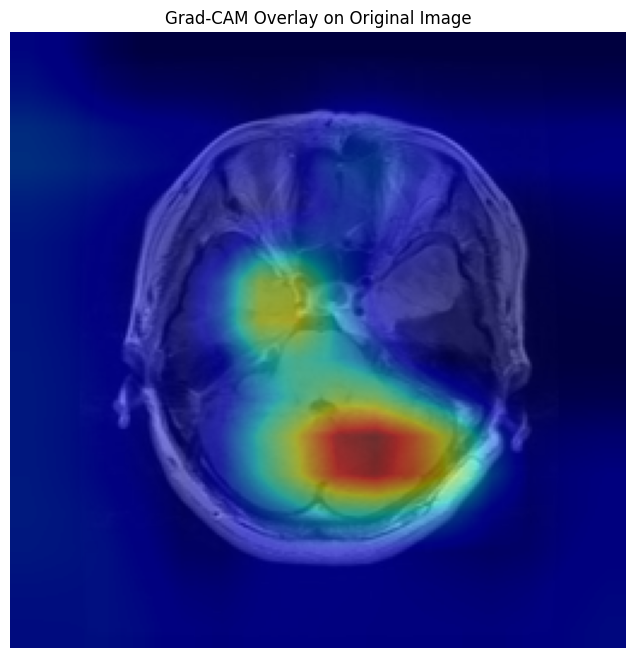

In [81]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the grad-CAM map from the saved file.
gradcam_batch = np.load("gradcam_maps/batch_0.npy")  # shape: (B, 16, 16, 1)
gradcam_map = np.squeeze(gradcam_batch[0])  # shape becomes (16, 16)

# Resize the Grad-CAM map to match the original image size (256x256)
heatmap_resized = cv2.resize(gradcam_map, (256, 256))
# Normalize heatmap to [0,1] for visualization
heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))

# Get the corresponding original grayscale image from X_train.
# Note: X_train is normalized to [0,1], so multiply by 255 to convert to proper uint8 range.
original_img = X_train[0]  # shape: (256,256,1)
original_img = np.squeeze(original_img)  # shape: (256,256)
original_img_rgb = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Overlay the heatmap on the original image.
plt.figure(figsize=(8, 8))
plt.imshow(original_img_rgb)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)  # Adjust alpha for transparency
plt.title("Grad-CAM Overlay on Original Image")
plt.axis("off")
plt.show()


In [ ]:
# Suppose we ended up with arrays:
#    images_unet.shape  -> (N, 256,256,1)
#    masks_unet.shape   -> (N, 256,256,1)
#    gradcams.shape     -> (N, 16,16,1)

# Convert them to TF tensors
images_unet_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
masks_unet_tf  = tf.convert_to_tensor(y_train, dtype=tf.float32)
gradcams_tf    = tf.convert_to_tensor(gradcams, dtype=tf.float32)

dataset_unet = tf.data.Dataset.from_tensor_slices(
    ((images_unet_tf, gradcams_tf), masks_unet_tf)
)
dataset_unet = dataset_unet.batch(batch_size=8, drop_remainder=False)

# Then just feed dataset_unet to your 2-input U-Net:
model_mod.fit(
    dataset_unet,
    epochs=10,
    validation_data=...,  # similarly constructed
)


In [74]:
import shutil

shutil.rmtree('/content/gradcam_maps')